In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

In [2]:
# Define the path to the directory containing the images
data_dir = 'images//'

# Define the target image size
height = 400
width = 400
channels = 3
target_size = (height, width)
target_shape = (height, width, channels)

# Define the class mode
class_mode = 'categorical' #'categorical' for multi-class classification

# Define the number of folds
k = 5

# Define the number of epochs for each fold
epochs = 10

# Define the batch size
batch_size = 32

# Define the data generator for data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

# Get the list of all image files in the directory
image_files = []
for folder in os.listdir(data_dir):
    image_files.extend(os.path.join(folder, file) for file in os.listdir(os.path.join(data_dir, folder)))

# Define the list of all image labels
labels = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']

# Convert the labels to a numpy array
labels = np.array(labels)

# Define the number of classes
num_classes = len(labels)

In [3]:
# Define and compile the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=target_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 396, 396, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 198, 198, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 128)      0

In [4]:
# Define the k-fold cross-validator
kf = KFold(n_splits=k, shuffle=True)

# Define a dictionary to store the history of the model for each fold
fold2history = {}

# Loop over the folds
for fold, (train_index, val_index) in enumerate(kf.split(image_files)):
    print(f'Fold {fold+1}/{k}')

    # Define the directories for training and validation data
    train_dir = os.path.join('kfolds', f'train_{fold}')
    val_dir = os.path.join('kfolds', f'val_{fold}')

    # Create the directories for training and validation data
    # if they exist delete them and create new ones
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Move the training images to the training directory
    for index in train_index:
        file = image_files[index]
        label = file.strip().split('\\')[0]
        label_dir = os.path.join(train_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy('images\\'+file, label_dir)

    # Move the validation images to the validation directory
    for index in val_index:
        file = image_files[index]
        label = file.strip().split('\\')[0]
        label_dir = os.path.join(val_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy('images\\'+file, label_dir)

    # Define the data generator for training data
    train_datagen = datagen.flow_from_directory(
            train_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode)

    # Define the data generator for validation data
    val_datagen = ImageDataGenerator(rescale=1./255).flow_from_directory(
            val_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode)

    # Train the model on the training data
    history = model.fit(train_datagen, epochs=epochs*k, validation_data=val_datagen, verbose=0)

    # Evaluate the model on the validation data
    loss, accuracy = model.evaluate(val_datagen)
    print(f'Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}')
    
    # Save the history of the model for each fold
    fold2history[fold] = history
    
# save the model
model.save('model.h5')

Fold 1/5
Found 470 images belonging to 7 classes.
Found 118 images belonging to 7 classes.
4/4 [==============================] - 1s 197ms/step - loss: 0.4551 - accuracy: 0.5763
Validation loss: 0.4551, Validation accuracy: 0.5763
Fold 2/5
Found 470 images belonging to 7 classes.
Found 118 images belonging to 7 classes.
4/4 [==============================] - 1s 204ms/step - loss: 0.1587 - accuracy: 0.8644
Validation loss: 0.1587, Validation accuracy: 0.8644
Fold 3/5
Found 470 images belonging to 7 classes.
Found 118 images belonging to 7 classes.
4/4 [==============================] - 1s 185ms/step - loss: 0.0100 - accuracy: 0.9915
Validation loss: 0.0100, Validation accuracy: 0.9915
Fold 4/5
Found 471 images belonging to 7 classes.
Found 117 images belonging to 7 classes.
4/4 [==============================] - 1s 187ms/step - loss: 0.0019 - accuracy: 1.0000
Validation loss: 0.0019, Validation accuracy: 1.0000
Fold 5/5
Found 471 images belonging to 7 classes.
Found 117 images belonging

In [5]:
history = []
for fold in range(k):
    history.extend(fold2history[fold].history['val_accuracy'])

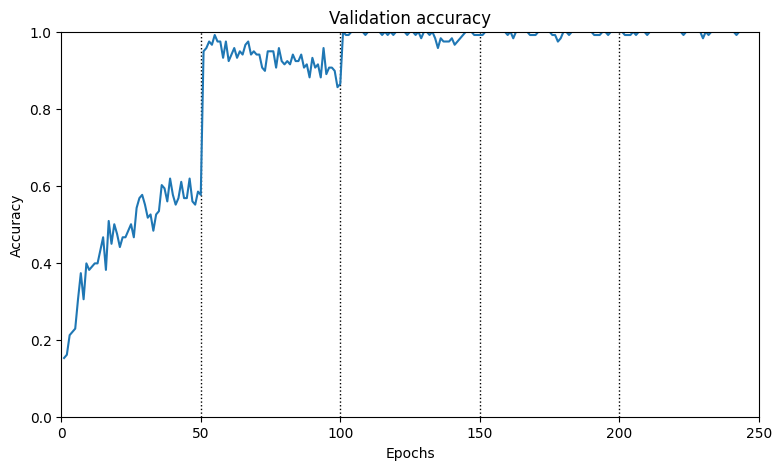

In [6]:
plt.figure(figsize=(9, 5))
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# set axis limits to show the plot clearly
plt.axis([0, len(history), 0, 1])

# draw dot lines for each fold
for i in range(1, k):
    plt.plot([i*epochs*k, i*epochs*k], [0, 1], 'k:', linewidth=1)
    
plt.plot(np.arange(1, len(history)+1), history, label='val_accuracy')

ValueError: in user code:

    File "c:\Users\Valerio\anaconda64\envs\cnn\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Valerio\anaconda64\envs\cnn\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Valerio\anaconda64\envs\cnn\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Valerio\anaconda64\envs\cnn\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Valerio\anaconda64\envs\cnn\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Valerio\anaconda64\envs\cnn\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 400, 400, 3), found shape=(None, 400, 3)


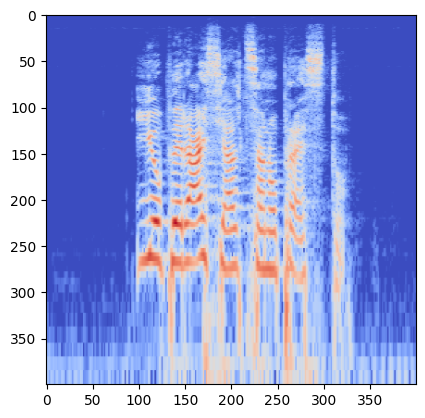

In [9]:
# predict the class of a single image
file = "images//dis//dis-f1-b1.wav.png"

img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, target_size)
plt.imshow(img)

pred = model.predict(img)
pred_class = labels[np.argmax(pred)]
pred_class